# Time Series Forecasting of VTSAX Prices - Classical vs Neural Methods

# Introduction

The main goal of this project is to perform a time-series forecasting on Vanguard Total Stock Market Index Fund Admiral Shares (VTSAX) index fund prices. Along the way, I am planning on tackling my second goal of the project, which is to successfully scrape data from the web to do the analysis on. After those objectives are met, I will be implementing a neural network approach for time-series to compare performance. 
<br>
<br>

This notebook focuses on the main goal of the project by performing analysis on the data and by constructing an autoregressive integrated moving average (ARIMA) model. I will be implementing the neural network appraoch on a separate notebook under the same Github folder. 

<br>

Vanguard Total Stock Market Index Fund Admiral Shares, or VTSAX for short, is a mutual fund offered by Vanguard, one of the world's largest investment companies. It is an index fund that tracks the performance of the entire US stock market. Buying a share essentially is like buying a fractional share of all companies traded in the US, and therefore allows you to diversify your investments with ease. Naturally, the performance of this index fund follows the performance of the overall US stock market.

<br>

The motive behind this project is to learn more about time-series analysis and neural networks through a hands-on approach. I chose to perform the analysis on VTSAX prices because forecasting its price has a practical use for me apart from it being a learning exercise. 

<br>

Disclaimer: The data gathered from Yahoo Finance is used only for non-commercial purposes.

# Part 1: Data Collection

The data I will be using will be from Yahoo Finance. Although the website offers historical stock data to be downloaded in a tabular format, the data will be gathered through a web scraper, as a part of the learning experience. I will use the Selenium library to perform the web scraping.

In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import requests
from selenium import webdriver


In [153]:
# Step 1: Specify which browser to use on Selenium and where the driver for it is located
from selenium import webdriver
PATH = 'C:\Program Files (x86)\chromedriver.exe'
driver = webdriver.Chrome('C:\Program Files (x86)\chromedriver.exe')

In [169]:
# Step 2: Open the yahoo finance website using the driver.get() method
url = 'https://finance.yahoo.com/quote/VTSAX/history?period1=974073600&period2=1609632000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true'
driver.get(url)

In [170]:
# Step 3: Scrape the HTML source code of the table where the data is located

table = driver.find_element_by_tag_name("table")


In [164]:
#Step 4: Analyze the structure of the table 


### The following output was made only using data from 12/17/2020 to 01/04/2021 to illustrate how dividend payment for VTSAX introduced
### noise that must be later addressed when scraping relevant information.

rows = table.find_elements_by_tag_name('tr') # Finds all rows of the table

for row in rows:
    cells = row.find_elements_by_tag_name('td')
    print(row.get_attribute('innerHTML'))
    print("\n")

<th class="Ta(start) W(100px) Fw(400) Py(6px)" data-reactid="36"><span data-reactid="37">Date</span></th><th class="Fw(400) Py(6px)" data-reactid="38"><span data-reactid="39">Open</span></th><th class="Fw(400) Py(6px)" data-reactid="40"><span data-reactid="41">High</span></th><th class="Fw(400) Py(6px)" data-reactid="42"><span data-reactid="43">Low</span></th><th class="Fw(400) Py(6px)" data-reactid="44"><span data-reactid="45">Close*</span></th><th class="Fw(400) Py(6px)" data-reactid="46"><span data-reactid="47">Adj Close**</span></th><th class="Fw(400) Py(6px)" data-reactid="48"><span data-reactid="49">Volume</span></th>


<td class="Py(10px) Ta(start) Pend(10px)" data-reactid="52"><span data-reactid="53">Dec 31, 2020</span></td><td class="Py(10px) Pstart(10px)" data-reactid="54"><span data-reactid="55">94.74</span></td><td class="Py(10px) Pstart(10px)" data-reactid="56"><span data-reactid="57">94.74</span></td><td class="Py(10px) Pstart(10px)" data-reactid="58"><span data-reactid="

################################# 

Disclaimer: I put an extra white space in the tag for Jupyter's Markdown to show the tag.

The "< th> " tag indicates the column headers of the table and the "< td>" tag indicates data point for each row. The start of each row is indicated by the "< tr>" tag. 
    
From this we can gather that this table has seven columns, and they are Date, Open, High, Low, Close, Adj Close, and Volume.

We can also see that there are some noises in this table that must be accomodated. The last row marked by the last "< td>" is actually not a row that contains any datapoints for our dataset. Rather, it hosts some supporting texts. We would need to place a mechanism in our scraper that will filter this last row correctly. Another noise is introduced from divident payment. This information is noted in the table in December 23rd, and the html parser read that information as a row with two datapoints. Fortunately, these noise rows contain less "< td>" tags than the rows with relevant information, so we can add a logic that will filter out these noises using this insight.

Now that we have an understanding of how to execute this scraping step, we will now construct the logic to do so. 

In [171]:
# Step 4: Since the website requires scrolling to load more data, command selenium to scroll until the bottom of the page to load all data

def scroll_to_bottom(driver):

    old_position = 0
    new_position = None

    while new_position != old_position:
        # Get old scroll position
        old_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                 " window.pageYOffset : (document.documentElement ||"
                 " document.body.parentNode || document.body);"))
        # Sleep and Scroll
        time.sleep(0.25)
        driver.execute_script((
                "var scrollingElement = (document.scrollingElement ||"
                " document.body);scrollingElement.scrollTop ="
                " scrollingElement.scrollHeight;"))
        # Get new position
        new_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                 " window.pageYOffset : (document.documentElement ||"
                 " document.body.parentNode || document.body);"))

scroll_to_bottom(driver)

In [172]:
# Step 5: After all data is loaded, scrape the data and append to empty lists.

# List of relevant data that will be zipped as columns of the dataset
date = []
open_ = []
high = []
low = []
close = []
adj_close = []
volume = []

# Data is found in the order of the variables in the columns list
columns = [date, open_, high, low, close, adj_close, volume]

rows = table.find_elements_by_tag_name('tr') # Finds all rows of the table

# Scraper that scrapes and appends relevant information to appropriate lists

for row in rows:
    cells = row.find_elements_by_tag_name('td') # Finds all data within the row for every row in the table
    if len(cells) > 2: # Filters out noise by not considering rows with only two data points
        for i in range(0,len(columns)):
            columns[i].append(cells[i].text) # appending relevant information to appropriate lists in the list of lists.
            

In [ ]:
# Step 6: Create a dataframe with the lists populated from the scraping
dataset = pd.DataFrame(zip(date, open_, high, low, close, adj_close, volume), 
                       columns = ["Date", "Open", "High", "Low", 
                                 "Close", "Adj Close", "Volume"])

In [174]:
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Dec 31, 2020",94.74,94.74,94.74,94.74,94.74,-
1,"Dec 30, 2020",94.28,94.28,94.28,94.28,94.28,-
2,"Dec 29, 2020",94.03,94.03,94.03,94.03,94.03,-
3,"Dec 28, 2020",94.40,94.40,94.40,94.40,94.40,-
4,"Dec 24, 2020",93.91,93.91,93.91,93.91,93.91,-
...,...,...,...,...,...,...,...
5060,"Nov 17, 2000",30.56,30.56,30.56,30.56,21.13,-
5061,"Nov 16, 2000",30.70,30.70,30.70,30.70,21.22,-
5062,"Nov 15, 2000",31.20,31.20,31.20,31.20,21.57,-
5063,"Nov 14, 2000",31.01,31.01,31.01,31.01,21.44,-


In [175]:
# Step 7: Close the browser
driver.quit()

In [176]:
# Saving the data to skip the scraping next time 
dataset.to_csv(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\Time Series Project\VTSAX_dataset.csv")

# Part 2: EDA

Now that the dataset is sucessfully scraped, the next steps will be to be familiarized with the data.

In [29]:
# Importing the dataset
dataset = pd.read_csv(r"C:\Users\taked\Desktop\DataScience Projects\Non-Kaggle Datasets\Time Series Project\VTSAX_dataset.csv").drop("Unnamed: 0", axis = 1)

In [30]:
# Not using head or tail to see both the first and the last rows of the dataset. 
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Dec 31, 2020",94.74,94.74,94.74,94.74,94.74,-
1,"Dec 30, 2020",94.28,94.28,94.28,94.28,94.28,-
2,"Dec 29, 2020",94.03,94.03,94.03,94.03,94.03,-
3,"Dec 28, 2020",94.40,94.40,94.40,94.40,94.40,-
4,"Dec 24, 2020",93.91,93.91,93.91,93.91,93.91,-
...,...,...,...,...,...,...,...
5060,"Nov 17, 2000",30.56,30.56,30.56,30.56,21.13,-
5061,"Nov 16, 2000",30.70,30.70,30.70,30.70,21.22,-
5062,"Nov 15, 2000",31.20,31.20,31.20,31.20,21.57,-
5063,"Nov 14, 2000",31.01,31.01,31.01,31.01,21.44,-


In [5]:
# Understanding the structures of each column
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5065 entries, 0 to 5064
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5065 non-null   object 
 1   Open       5065 non-null   float64
 2   High       5065 non-null   float64
 3   Low        5065 non-null   float64
 4   Close      5065 non-null   float64
 5   Adj Close  5065 non-null   float64
 6   Volume     5065 non-null   object 
dtypes: float64(5), object(2)
memory usage: 277.1+ KB


From the code above, we can see that the type of all columns are object, meaning that the values stored in that column are strings. Ideally, we would want the Date column to be a datetime type and the remaining columns to be a numerical.

In [31]:
# Drop the Volume column
dataset = dataset.drop("Volume", axis = 1)

# Convert all but the Date column to be a numerical column and the Date column to be a datetime column.
dataset["Date"] = pd.to_datetime(dataset["Date"])
numerical_columns = list(dataset.drop("Date", axis = 1).columns)
for column in numerical_columns:
    dataset[column] = pd.to_numeric(dataset[column])
    


For this project, I will be first training the two models with data from 2000 to 2018, and forecast prices for 2019. This is because the volatility of stock prices in 2020 will be extremely difficult for predictive models to predict with data from 2000 to 2019. 

In [32]:
dataset["year"] = dataset["Date"].dt.year
volatile_data = dataset[dataset["year"] == 2020]
test_set = dataset[dataset["year"] == 2019]
dataset = dataset[dataset["year"] < 2019]

In [8]:
dataset

,Date,Open,High,Low,Close,Adj Close,year
505,2018-12-31,62.09,62.09,62.09,62.09,59.87,2018
506,2018-12-28,61.55,61.55,61.55,61.55,59.35,2018
507,2018-12-27,61.57,61.57,61.57,61.57,59.37,2018
508,2018-12-26,61.08,61.08,61.08,61.08,58.90,2018
509,2018-12-24,58.19,58.19,58.19,58.19,56.11,2018
...,...,...,...,...,...,...,...
5060,2000-11-17,30.56,30.56,30.56,30.56,21.13,2000
5061,2000-11-16,30.70,30.70,30.70,30.70,21.22,2000
5062,2000-11-15,31.20,31.20,31.20,31.20,21.57,2000
5063,2000-11-14,31.01,31.01,31.01,31.01,21.44,2000


For this analysis I will be analyzing the change in Adjusted Closing prices, as profit or loss with stocks are determined by the closing price, after adjustments for corporate actions.
Now we will take a look at how the final closing prices of VTSAX have changed over the years. 

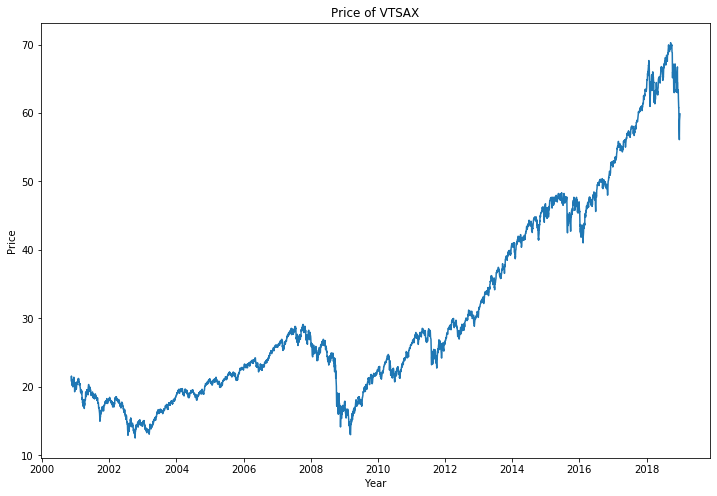

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Price of VTSAX")
plt.plot(dataset["Date"], dataset["Adj Close"])

# Stationarity

Stationarity of series is required to pick a good forecasting model. If the data is stationary both for mean and variance, then the data should have a constant mean with constant scattering around the mean across time. The plot above shows an upward trend, signifying that the series is not stationary. Therefore, transforming the data may be suited. 
<br>
<br>
There are a couple of quantitative ways to determine whether the series is stationary. One way is to look at the autocorrelation function (ACF) and the partial autocorrelation function (PACF) of the series. For a stationary series, both the ACF and PACF should drop to zero quickly.

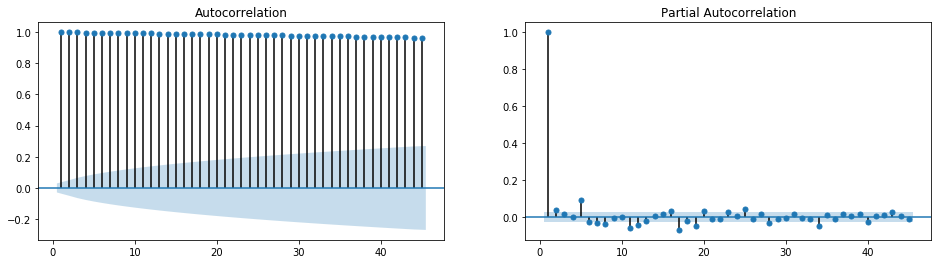

In [10]:
# Observe the ACF of the series and PACF of the series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize = (16, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plot_acf(dataset["Adj Close"], ax = ax1, lags = 45, zero = False)
plot_pacf(dataset["Adj Close"], ax = ax2, lags = 45, zero = False)
plt.show()

The ACF plot shows that the autocorrelations are not droppoing to zero, meaning that the series is not stationary.
<br>
Another way to determine staionarity of series is to do a decomposition of the series into subcomponents. These subcomponents are trend, seasonality, and irregularity (residuals).


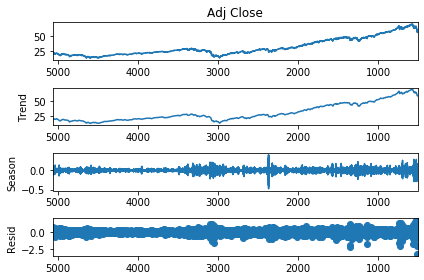

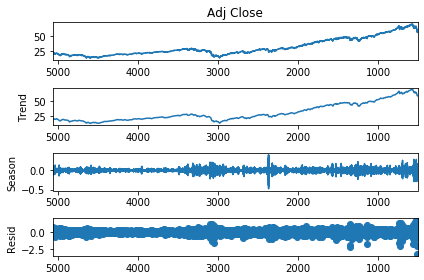

In [61]:
# Using .iloc[::-1] to flip the series, as the dataframe starts from 2021 and goes to 2000, while we want the data to start from 2000 and 
# go to 2021.
from statsmodels.tsa.seasonal import STL
result = STL(dataset["Adj Close"].iloc[::-1], trend = 15, period = 2).fit()
result.plot()

When the series is broken down to trend, seasonality, and residual, we see that the trend is an exponential growth. This trend is computed as the moving average of 15 datapoints. The presence of a trend confirms that the series is indeed not stationary.
<br>
<br>
There are two kinds of non-stationarity that must be accounted for prior to modeling and forecasting. They are the non-stationarity in the mean and non-stationarity in the variance. Non-stationarity in the mean is easy to detect visually; if the time-plot of the series does not seem to oscillate around an imaginary horizontal line, then mean is changing over time, and therefore is not stationary in the mean. This is combatted by taking the first difference of the series. Differencing refers to how much the value of the series has changed between current observation and the observation one period ago. Non-stationarity in the variance is more difficult to detect visually. If there is non-stationarity in variance, then the series should show no change in variance over time. For a series with an exponential growth such as this one, we can take the natural log of the series to smooth out the non-stationary variance.
<br>
<br>
Now we will take the first difference of the series to combat non-stationarity in the mean.

In [33]:
# Taking the first difference of the dataframe. Resulting values in every column will be the first difference between obs. at t and t-1 
diff = dataset.diff()

In [34]:
dataset["adj-diff"] = diff["Adj Close"]

In [35]:
dataset

,Date,Open,High,Low,Close,Adj Close,year,adj-diff
505,2018-12-31,62.09,62.09,62.09,62.09,59.87,2018,NaN
506,2018-12-28,61.55,61.55,61.55,61.55,59.35,2018,-0.52
507,2018-12-27,61.57,61.57,61.57,61.57,59.37,2018,0.02
508,2018-12-26,61.08,61.08,61.08,61.08,58.90,2018,-0.47
509,2018-12-24,58.19,58.19,58.19,58.19,56.11,2018,-2.79
...,...,...,...,...,...,...,...,...
5060,2000-11-17,30.56,30.56,30.56,30.56,21.13,2000,0.50
5061,2000-11-16,30.70,30.70,30.70,30.70,21.22,2000,0.09
5062,2000-11-15,31.20,31.20,31.20,31.20,21.57,2000,0.35
5063,2000-11-14,31.01,31.01,31.01,31.01,21.44,2000,-0.13


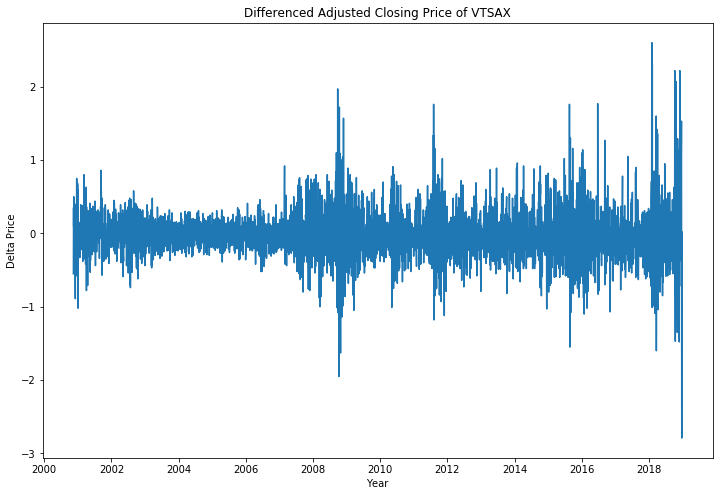

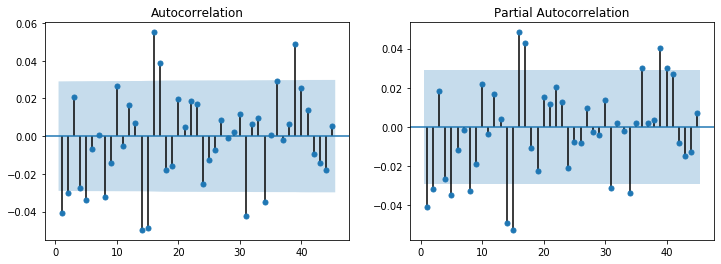

In [66]:
# Plot the differenced series
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.xlabel("Year")
plt.ylabel("Delta Price")
plt.title("Differenced Adjusted Closing Price of VTSAX")
plt.plot(dataset["Date"], dataset["adj-diff"])

# Plot ACF and PACF of the differenced series. Plotting the plots from the second row, as the series value for the first row is null.
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plot_acf(dataset["adj-diff"][1:], ax = ax1, lags = 45, zero = False)
plot_pacf(dataset["adj-diff"][1:], ax = ax2, lags = 45, zero = False)
plt.show()


There is a visually apparent mean that is around 0. This data is now non-stationary around the mean. 
<br>
Now we will do the same procedure with the log-transformed version of the series to see if that will yield a more staionary series for us to model.

In [36]:
# Trying log tranformations

dataset["log-adj"] = np.log(dataset["Adj Close"])

# Calculating the first difference for the log-transformed series and adding it to the original dataset.
logged_diff = dataset.diff()
dataset["log-adj-diff"] = logged_diff["log-adj"]

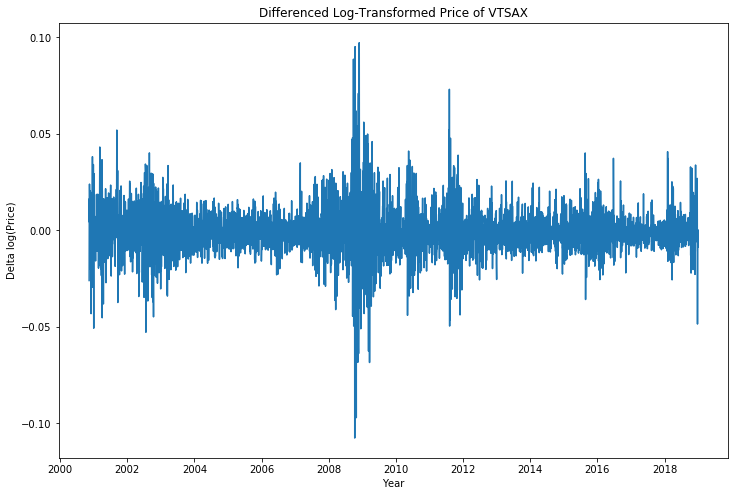

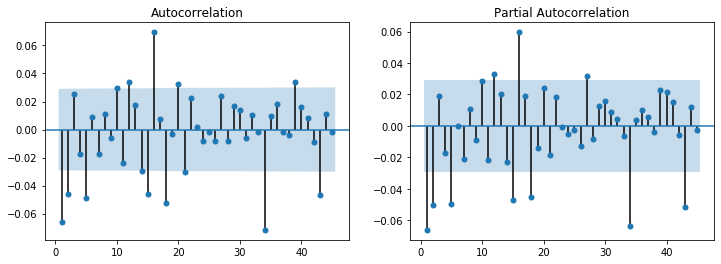

In [68]:
# Plot the differenced log-transformed series
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.xlabel("Year")
plt.ylabel("Delta log(Price)")
plt.title("Differenced Log-Transformed Price of VTSAX")
plt.plot(dataset["Date"], dataset["log-adj-diff"])

# Plot ACF and PACF of the differenced series. Plotting the plots from the second row, as the series value for the first row is null.
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plot_acf(dataset["log-adj-diff"][1:], ax = ax1, lags = 45, zero = False)
plot_pacf(dataset["log-adj-diff"][1:], ax = ax2, lags = 45, zero = False)
plt.show()

Although the time plot does suggest that the variance is more controlled for the log-transformed plot, the ACF/PACF for the log-transformed plot shows more variability, along with more partial autocorrelations. Correlations between two different time periods are said to be autocorrelated and partially autocorrelated if its correlation coefficient, r sub k, is lies outside the boundaries set between +- 2/(n)^0.5 where n is the number of observations. This boundary is shaded in blue in the ACF and PACF. 
<br>
We know that stock market prices are susceptible to volatility that result in outlier values due to real-life events such as recessions. This volatility makes it difficult to reach complete stationarity with stock market data, and hence is challenging to create a high performing forecasting model. With that being said, we have more methods to test stationarity, such as the unit-root test. The null-hypothesis for this test is that the series is non-stationary, and has time-dependent structure, while the alternative is that the series is stationary. If the test confirms that the series is still not stationary, we can try removing the outliers from the data. 

In [69]:
# Perform the augmented Dickey-Fuller unit-root test on differenced original Open value
from statsmodels.tsa.stattools import adfuller
result = adfuller(dataset["adj-diff"][1:])
print("##### First difference on original series #####")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
    
print("\n")

# Perform the augmented Dickey-Fuller unit-root test on differenced log-transformed Open value

result = adfuller(dataset["log-adj-diff"][1:])
print("##### First difference on log-transformed series #####")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

##### First difference on original series #####
ADF Statistic: -16.842368
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


##### First difference on log-transformed series #####
ADF Statistic: -16.356839
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Fortunately, the augmented Dickey-Fuller test confirmed that the series are stationary. The unit-root test with the untransformed series yielded a lower test statistic, and lower test statistic signifies that there is a lower probability of a type 1 error. Although the difference in test statistic is marginal, I will continue the analysis using the untransformed series.

The ACF and PACF of stationary data tells us informations regarding to what kind of forecasting models should be tried. However, it is difficult to grasp concrete information about model selection from our ACF and PACF as there are irregularities in autocorrelations/partial autocorrelations. One reason for this case may be due to the fact that these are daily stock data, and therefore it is difficult to extrapolate repeating (seasonal) patterns. Hence, I will try to wrangle the data to create monthly data and see if seasonality becomes more apparent.

In [37]:
# Create a monthly dataset by extracting the first rows of every month for every year from the original dataset
dataset["month"] = dataset["Date"].dt.month
dataset["day"] = dataset["Date"].dt.day
df1 = dataset.set_index('Date')
df1.sort_index(inplace=True)

monthly_data = df1.groupby(pd.Grouper(freq = 'MS')).nth(0)

In [38]:
monthly_data.reset_index(inplace = True)


In [39]:
monthly_data

,Date,Open,High,Low,Close,Adj Close,year,adj-diff,log-adj,log-adj-diff,month,day
0,2000-11-01,30.22,30.22,30.22,30.22,20.89,2000,-0.55,3.039271,-0.025988,11,13
1,2000-12-01,29.08,29.08,29.08,29.08,20.10,2000,-0.08,3.000720,-0.003972,12,1
2,2001-01-01,28.28,28.28,28.28,28.28,19.62,2001,-1.02,2.976549,-0.050681,1,2
3,2001-02-01,30.51,30.51,30.51,30.51,21.16,2001,0.39,3.052113,0.018603,2,1
4,2001-03-01,27.53,27.53,27.53,27.53,19.10,2001,0.09,2.949688,0.004723,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
213,2018-08-01,70.55,70.55,70.55,70.55,67.32,2018,-0.41,4.209457,-0.006072,8,1
214,2018-09-01,72.95,72.95,72.95,72.95,69.61,2018,0.22,4.242908,0.003165,9,4
215,2018-10-01,72.95,72.95,72.95,72.95,69.95,2018,0.12,4.247781,0.001717,10,1
216,2018-11-01,68.29,68.29,68.29,68.29,65.48,2018,0.35,4.181745,0.005359,11,1


In [19]:
monthly_diff = monthly_data.diff()

In [20]:
monthly_data["adj-diff"] = monthly_diff["Adj Close"]
monthly_data["log-adj-diff"] = monthly_diff["log-adj"]

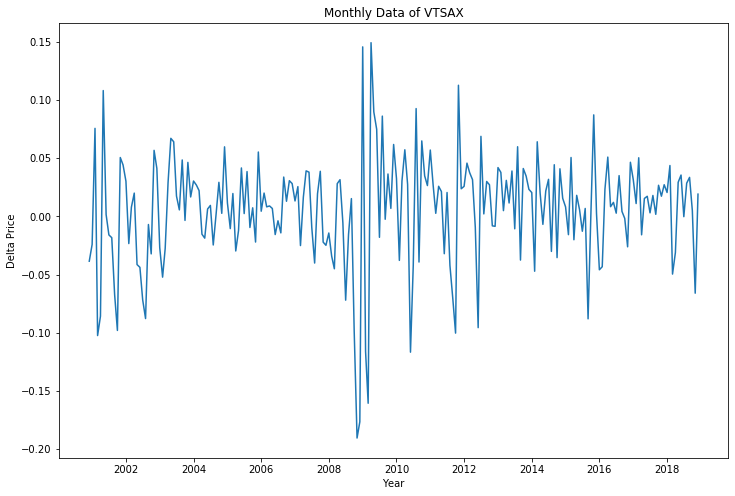

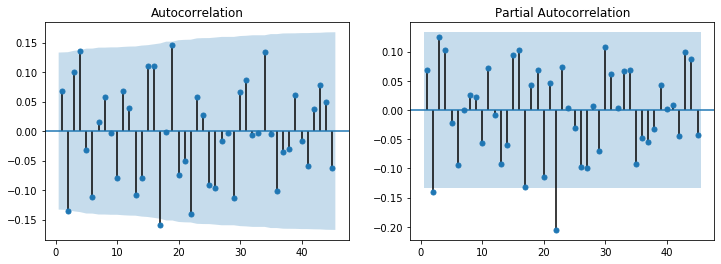

In [78]:
# Plot the monthly log-transformed differenced series
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.xlabel("Year")
plt.ylabel("Delta Price")
plt.title("Monthly Data of VTSAX")
plt.plot(monthly_data["Date"], monthly_data["log-adj-diff"])

# Plot ACF and PACF of the differenced series. Plotting the plots from the second row, as the series value for the first row is null.
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plot_acf(monthly_data["log-adj-diff"][1:], ax = ax1, lags = 45, zero = False)
plot_pacf(monthly_data["log-adj-diff"][1:], ax = ax2, lags = 45, zero = False)
plt.show()

Unfortunately, the ACF/PACF of the monthly data do not hint us which models to use. However, it is clearer to see that the variability in the observations are scattered randomly after taking the first difference from original data. This hints that the series is a random walk (value at current time is equal to value at previous time plus normally distributed error). This random walk is an ARIMA(0,1,0)(0,0,0) model, as it shows no signs of obvious indicators to use an autoregressive (AR) model or a moving average (MA) model after taking the first difference. Since there is no apparent seasonality from these plots, the seasonal components of the ARIMA model are zeroes (0,0,0). 
<br>
<br>
With this in mind, our current model of choice is ARIMA(0,1,0) AKA I(1). If there is no clear indication of a model to use from ACF/PACF of a stationary series, then it is a potential indicator that a mixture of models may suffice. In our next phase of analysis, we will compare forecast performance of numerous of ARIMA models.

# Part 3: Modeling

Now, several variations of ARIMA models will be constructed and evaluated. The pmdarima package automates this process by fitting numerous ARIMA models to the dataset and returns the model with the lowest evaluation metrics, such as AIC and BIC.

In [21]:
dataset

,Date,Open,High,Low,Close,Adj Close,year,adj-diff,log-adj,log-adj-diff,month,day
505,2018-12-31,62.09,62.09,62.09,62.09,59.87,2018,NaN,4.092176,NaN,12,31
506,2018-12-28,61.55,61.55,61.55,61.55,59.35,2018,-0.52,4.083452,-0.008723,12,28
507,2018-12-27,61.57,61.57,61.57,61.57,59.37,2018,0.02,4.083789,0.000337,12,27
508,2018-12-26,61.08,61.08,61.08,61.08,58.90,2018,-0.47,4.075841,-0.007948,12,26
509,2018-12-24,58.19,58.19,58.19,58.19,56.11,2018,-2.79,4.027314,-0.048527,12,24
...,...,...,...,...,...,...,...,...,...,...,...,...
5060,2000-11-17,30.56,30.56,30.56,30.56,21.13,2000,0.50,3.050694,0.023948,11,17
5061,2000-11-16,30.70,30.70,30.70,30.70,21.22,2000,0.09,3.054944,0.004250,11,16
5062,2000-11-15,31.20,31.20,31.20,31.20,21.57,2000,0.35,3.071303,0.016359,11,15
5063,2000-11-14,31.01,31.01,31.01,31.01,21.44,2000,-0.13,3.065258,-0.006045,11,14


In [53]:
# Fit different ARIMA models and compare results
from pmdarima import auto_arima
auto_arima(dataset["Adj Close"], start_p=0, d=None, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, 
           max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aicc', alpha=0.05, 
           test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', 
           offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='warn', 
           trace=True, random=False, random_state=None, n_fits=50)

Performing stepwise search to minimize aicc
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AICC=2816.216, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AICC=2822.360, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AICC=2816.710, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AICC=2823.425, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AICC=2811.439, Time=1.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AICC=2813.999, Time=2.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AICC=2814.206, Time=1.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AICC=2814.203, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AICC=2814.053, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AICC=2799.107, Time=5.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AICC=2813.502, Time=5.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AICC=2813.815, Time=5.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AICC=2816.024, Time=2.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AICC=2815.799, Time=1.98 sec
 ARIMA(3,1,3)(0,0,

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

As expected from our previous analyses, the final ARIMA model has one integration term (I = 1, meaning first differenced), and is a mixture of AR and MA models. Note that the models above were fit to the undifferenced, original data. Had the models been fit with the differenced data (adj-diff), then the resulting ARIMA model would  have been a (2,0,2).
<br>
<br>
Before moving on to forecasting using this model, we must confirm that the residuals resulting from this model is white noise. A white noise residual plot should have residuals randomly scattered around 0 that is stable with respect to time. We will plot a time plot and the ACF/PACF plot to determine whether the residuals are white noise.

In [124]:
# Compute the residuals from ARIMA(2,1,2) model. 
from pmdarima.arima import ARIMA
arima = ARIMA(order = (2,1,2))
arima.fit(dataset["Adj Close"])
residuals = arima.resid()

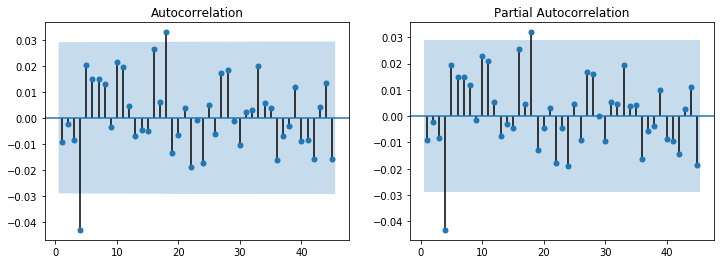

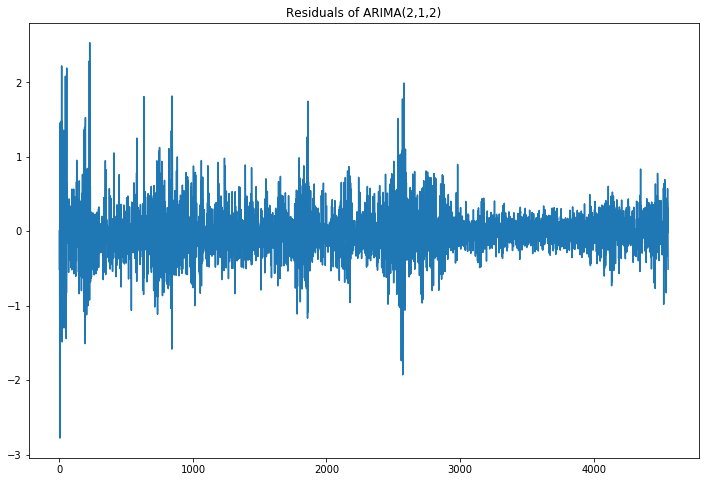

In [125]:
plt.figure(figsize = (12, 8))
plt.title("Residuals of ARIMA(2,1,2)")
plt.plot(residuals[1:]) # Plotting starting from the second residual because the first residual is an extreme outlier
fig = plt.Figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plot_acf(residuals, ax = ax1, lags = 45, zero = False)
plot_pacf(residuals, ax = ax2, lags = 45, zero = False)



Unfortunately, there are signs of autocorrelations and partial autocorrelations, which signify that the model does not yield a white noise residual plot. There is another statistical testing that can determine whether the residuals resemble a white noise model. We can run a portmanteau test on the residuals to determine whether there are autocorrelations in the residuals.

In [98]:
# Conduct portmanteau test to find autocorrelations
from statsmodels.stats.diagnostic import acorr_ljungbox
portmanteau = acorr_ljungbox(residuals, model_df = 4, return_df = True) #model_df = p + q = 2 + 2

# Showing cases when the test statistic is significant (indicating autocorrelation)
portmanteau[portmanteau["lb_pvalue"] >= 0.05].head(5)

C:\Users\taked\AppData\Roaming\Python\Python37\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)


,lb_stat,lb_pvalue
14,18.201922,0.051652
15,18.317927,0.074491
17,21.726079,0.059754
23,29.385962,0.060152
24,30.739896,0.058719


The portmanteau test returns that some residuals are autocorrelated and therefore we may be able to create better forecasting using a different model. 
<br>
<br>
I suspect this lack of model performance stems from underlying seasonality in the data that is difficult to account for using daily data. From now on I will be trying the monthly data and see if I can create a better model using monthly data.
<br>
<br>
For the monthly data I will be using from the second row and on, because the first row is from November 13 of the year 2000, while all other rows start on the 1st of every month. Therefore, the number of days between the first row and the second row compared to that of other rows are incongruent. 

In [42]:
# Dropping the first row of monthly data
new_monthly_data = monthly_data[1:]

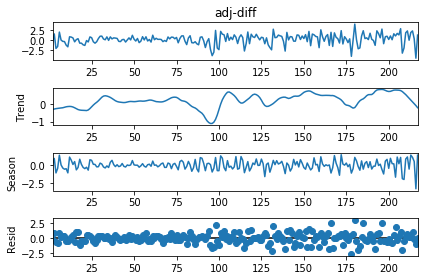

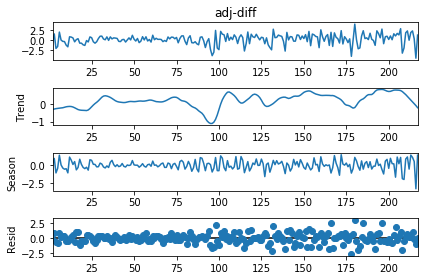

In [205]:
# Performing a series decomposition on the monthly adjusted closing price 
result = STL(new_monthly_data["adj-diff"][1:], trend = 15, period = 12).fit()
result.plot()

Although the residuals seem to have an unstable variance, there seems to be a pattern in seasonality. Keeping this in mind, we will now create different ARIMA models and compare based off of their AICC values.

In [ ]:
# Cleared the output as the output takes space.
auto_arima(new_monthly_data["Adj Close"], start_p=0, d=1, start_q=1, max_p=4, max_d=3, max_q=4, start_P=1, D=None, start_Q=1, max_P=2, 
           max_D=2, max_Q=2, max_order=None, m=12, seasonal=True, stationary=False, information_criterion='aicc', alpha=0.05, 
           test='kpss', seasonal_test='ocsb', stepwise=False, n_jobs=1, start_params=None, trend=None, method='lbfgs', 
           offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='warn', 
           trace=True, random=False, random_state=None, n_fits=50)

The output of the autoarima function dictated that the model that yielded the lowest AICc was the ARIMA(2,1,2) model with no seasonal components. Now we will fit the training data and see if it yields a white noise residual.

In [44]:
# Compute the residuals from ARIMA(2,1,2) model. This model resulted in white noise residuals
from pmdarima.arima import ARIMA
arima = ARIMA(order = (2,1,2),seasonal_order=(0, 0, 0, 12))
arima.fit(new_monthly_data["Adj Close"])
residuals = arima.resid()

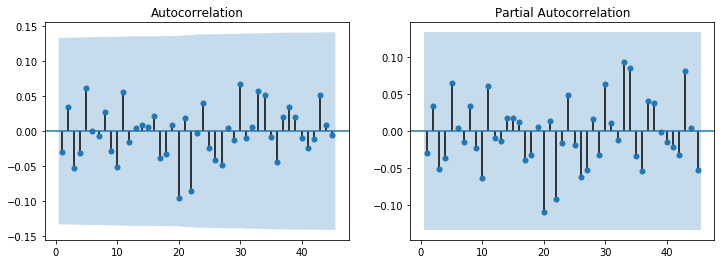

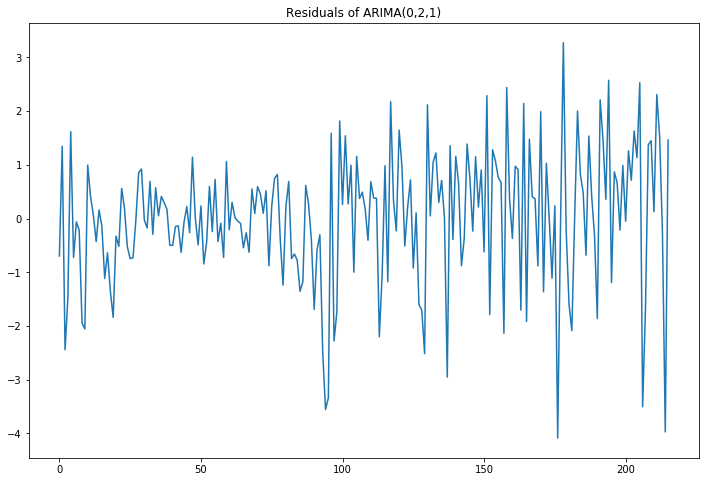

In [207]:
# Plotting diagnostics of the model
plt.figure(figsize = (12, 8))
plt.title("Residuals of ARIMA(0,2,1)")
plt.plot(residuals[1:]) # Plotting starting from the second residual because the first residual is an extreme outlier
fig = plt.Figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plot_acf(residuals, ax = ax1, lags = 45, zero = False)
plot_pacf(residuals, ax = ax2, lags = 45, zero = False)

At last, a model with white noise residuals! Our final model of choice is an ARIMA(2,1,2)(0,0,0), meaning an ARIMA model with no seasonal components. Just in case, we will also be forecasting with the ARIMA models that yielded the two lowest AICc behind our chosen model, which were ARIMA(2,1,2) with (1,0,0) and (0,0,1) seasonal components. We will forecast 2019 stock prices with the three models, compare performance, and the highest performing model will be compared to a modern forecasting model, LSTM.

# Part 4 Forecasting

Now that we are ready to forecast using the ARIMA models, we must first transform the test set (2019) data to the same format as the training data in order to accurately evaluate the model predictions.

In [58]:
# Create a monthly dataset by extracting the first rows of every month for every year from the original dataset
test_set["month"] = test_set["Date"].dt.month
test_set["day"] = test_set["Date"].dt.day
df1 = test_set.set_index('Date')
df1.sort_index(inplace=True)

monthly_test = df1.groupby(pd.Grouper(freq = 'MS')).nth(0)

# Preprocessing of data for visualization
monthly_test["predictions"] = preds

monthly_clone = pd.DataFrame.copy(monthly_test)

full_monthly_test = monthly_test[["Adj Close"]]

new_full = new_monthly_data.set_index("Date")
new_full = new_full[["Adj Close"]]

# Creating a master dataframe used for visualization
full_data = pd.concat([new_full,full_monthly_test], axis = 0)

In [106]:
# Comparing forecasts of several models
def get_forecast (p,d,q,P,D,Q):
    monthly_clone = pd.DataFrame.copy(monthly_test)
    arima = ARIMA(order = (p,d,q),seasonal_order=(P, D, Q, 12),
                  maxiter = 50, method= 'lbfgs', suppress_warnings= True)
    arima.fit(new_monthly_data["Adj Close"])
    residuals = arima.resid()

    # Predict the next 12 months usin gthe trained model 
    preds, conf_95 = arima.predict(n_periods = 12, return_conf_int = True, alpha = 0.05)
    conf_df = pd.DataFrame(conf_95, index = monthly_test.index)
    monthly_clone["predictions"] = preds
    
    plt.plot(full_data["Adj Close"][150:], label='observed')
    plt.plot(monthly_clone["predictions"], label = "predicted")
    # pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    plt.fill_between(conf_df.index,
                conf_df.iloc[:, 0],
                conf_df.iloc[:, 1], color='k', alpha=.2)

    plt.legend()
    plt.show()
    


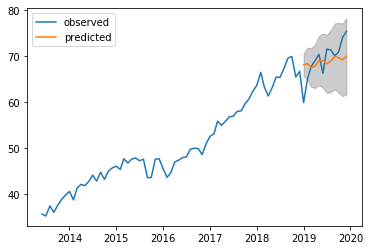

In [107]:
# Compare the three models visually
get_forecast(2,1,2,0,0,0)

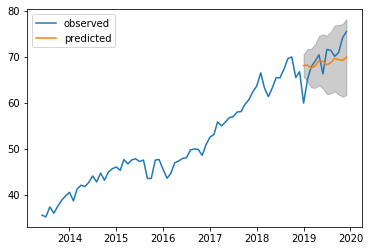

In [97]:
get_forecast(2,1,2,1,0,0)

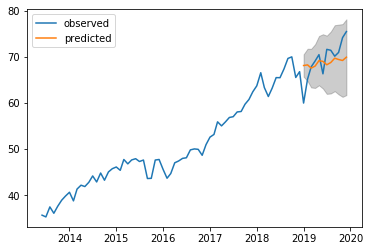

In [133]:
get_forecast(2,1,2,1,0,1)

All three ARIMA models made a 95% confidence interval that includes the actual observed data, except for the first month of 2019. This is probably due to the steep decline in price for the first month of 2019 that does not follow the pattern leading up to it. Because it is difficult to visually determine which model performed the best, we will now quantify model performances and compare results. For the evaluation of the models, I will be using mean absolute percentage error (MAPE). The reason why I am using MAPE over root mean squared error (RMSE) is because of the first month of 2019 has an adjusted closing price far lower than what is expected from the trend, and thus will result in large error terms. RMSE magnifies large errors by squaring the errors, and thus I will use the metric that is less sensitive to outliers, MAPE. I will now compare the MAPE of the ARIMA models and see if they can out perform naive forecasts, which take the value of the previous period's adjusted closing price as the forecast for the next period's adjusted closing price.

In [167]:
# Get MAPE of naive forecasting
naive_forecasts = full_data[-13:-1] # Treating naive forecasts as adjusted closing price of the preceding month. 
perc_error = 100*(naive_forecasts["Adj Close"] - actual.values)/actual.values
mape = np.mean(np.abs(perc_error))
print("MAPE of naive forecasts: ",mape)

MAPE of naive forecasts:  4.175766902575538


In [165]:
# Create a utility function to find MAPE of forecasts
def get_mape (p,d,q,P,D,Q):
    monthly_clone = pd.DataFrame.copy(monthly_test)
    arima = ARIMA(order = (p,d,q),seasonal_order=(P, D, Q, 12),
                  maxiter = 50, method= 'lbfgs', suppress_warnings= True)
    arima.fit(new_monthly_data["Adj Close"])

    # Predict the next 12 months usin gthe trained model 
    preds, conf_95 = arima.predict(n_periods = 12, return_conf_int = True, alpha = 0.05)
    
    actual = monthly_clone["Adj Close"]
    perc_error = 100*(preds - actual)/actual
    mape = np.mean(np.abs(perc_error))
    
    return mape

In [166]:
# Get MAPE of forecasts
arima_212_000 = get_mape(2,1,2,0,0,0)
arima_212_100 = get_mape(2,1,2,1,0,0)
arima_212_101 = get_mape(2,1,2,1,0,1)

print("MAPE of ARIMA(2,1,2)(0,0,0): %.5f" % (arima_212_000))
print("MAPE of ARIMA(2,1,2)(1,0,0): %.5f" % (arima_212_100))
print("MAPE of ARIMA(2,1,2)(1,0,1): %.5f" % (arima_212_101))

MAPE of ARIMA(2,1,2)(0,0,0): 4.20869
MAPE of ARIMA(2,1,2)(1,0,0): 4.27435
MAPE of ARIMA(2,1,2)(1,0,1): 4.05118


Out of the three, the MAPE of ARIMA(2,1,2)(1,0,1) was the lowest. Also, it was the only model out of the three that outperformed naive forecasting. Thus, for this time series analysis we found ARIMA(2,1,2)(1,0,1) model to be the best model to forecast the monthly changes in VTSAX adjusted closing prices.

# Conclusion

This has been part 1 of my project of time series analysis and forecasting comparison between classical and modern methods. In this notebook, I analyzed the data through extensive exploratory data analysis. I found the most appropriate ARIMA models to use for this specific dataset, and constructed a model that scored a mean absolute percentage error of 4.05%, outperforming naive forecasting. As a bonus part of this project, I will construct a Long Short-Term Memory (LSTM) neural network model and see if it can forecast with less than 4.05% mean absolute percentage error.